In [24]:
import numpy as np
import matplotlib.pyplot as plt
from regions import Regions
import regions
from astropy.io import fits
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy import units as u
from astroquery.vizier import Vizier
from astropy.table import Table, Column, MaskedColumn
from astropy import table

from smart_plotters.jwst_plots import JWSTCatalog, make_cat_use, make_brick_cat
from smart_plotters.vvv_plots import VVVCatalog, make_vvv_cat
from smart_plotters.cutout_plot import get_cutout_405, get_cutout_jwst_ice
from smart_plotters import cmd_plot

In [2]:
cat_use = make_cat_use()

In [3]:
fn = '/orange/adamginsburg/jwst/cloudc/images/jw02221-o002_t001_nircam_clear-f405n-merged_i2d.fits'
hdu = fits.open(fn)
ww = WCS(hdu['SCI'].header)
nanfield = np.nan * hdu['SCI'].data

In [4]:
pos = SkyCoord('17:46:21.3783484075', '-28:35:40.1619795493', unit=(u.hourangle, u.deg), frame='icrs')
# l = 2.6*u.arcmin
# w = 8.4*u.arcmin
# reg = regions.RectangleSkyRegion(pos, width=l, height=w)
# cutout_405 = get_cutout_405(pos, w=l, l=w)
basepath = '/orange/adamginsburg/jwst/cloudc/'
reg_fov = Regions.read(f'{basepath}/regions_/f4_fov_cloudc.reg')[0]

Vizier.ROW_LIMIT = 5e5
#Vizier.VIZIER_SERVER = 'vizier.cds.unistra.fr'
#Vizier.TIMEOUT = 120
cat_VVV = Vizier.query_region(coordinates=pos, width=4*u.arcmin, height=9*u.arcmin, catalog=['II/387/virac2'])[0]
#Vizier.get_catalogs('II/387/virac2')[0]
#Vizier.query_region(coordinates=pos, width=l, height=w, catalog=['II/387/virac2'])[0]
cat_VVV = VVVCatalog(cat_VVV)
cat_VVV = VVVCatalog(cat_VVV.catalog[cat_VVV.get_region_mask([reg_fov], ww)])
cat_VVV.catalog

srcid,RAJ2000,DEJ2000,Nep,e_RAJ2000,e_DEJ2000,plx,e_plx,pmRA,e_pmRA,pmDE,e_pmDE,Chi2,UWE,Zmag,e_Zmag,o_Zmag,Ymag,e_Ymag,o_Ymag,Jmag,e_Jmag,o_Jmag,Hmag,e_Hmag,o_Hmag,Ksmag,e_Ksmag,o_Ksmag,KsEp1,KsEpl,KsSkew,MedKsmag,e_MedKsmag,SIKsmag,SJKsmag,SKKsmag,NSIobs,etaKs,etaKsMod
,deg,deg,,mas,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,mag,mag,,d,d,,mag,mag,,,,,,
int64,float64,float64,int16,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,int16,float64,float32,int16,float64,float32,int16,float64,float32,int16,float64,float32,int16,float64,float64,float64,float64,float64,float64,float64,float64,int16,float64,float64
13505497009008,266.595312614038,-28.657673543607,202,3.36871533,3.57433294,1.29623148,4.95119705,-4.29806063,2.08586393,2.21442064,1.99676671,165.83,0.644677,--,--,0,--,--,0,--,--,0,17.2760,0.0957,11,15.5311,0.1001,202,55777.13705928,58363.03114536,-0.060358,0.065593,0.128668,0.1129,-0.1099,0.7813,69,1.7748,824845760
13505497012314,266.595319321445,-28.657053466991,175,9.1722163,7.40167845,5.3060098,12.8363598,-4.48665963,4.67073426,-10.581254,4.12193638,148.04,0.655057,--,--,0,--,--,0,--,--,0,--,--,0,16.6067,0.1775,175,55423.17848052,58363.03114536,-0.031806,0.123966,0.241944,0.1107,-0.1113,0.7650,60,1.9325,885793661.7
13505497000684,266.596501754724,-28.655964364930,113,10.8026757,8.74883809,4.27900952,15.4762903,7.16573626,6.12068007,6.36459745,5.05046477,102.52,0.681103,--,--,0,--,--,0,--,--,0,--,--,0,16.6766,0.1838,113,55777.13705928,58363.03076606,0.470635,0.122532,0.259415,0.1596,-0.0577,0.8183,37,1.2506,394419369.4
13505497013682,266.595554788933,-28.655906565695,206,6.92921077,4.42377708,5.09919752,9.6998324,1.16106719,3.68865243,-4.66911494,3.16670921,111.62,0.523698,--,--,0,--,--,0,--,--,0,--,--,0,16.5876,0.1547,206,55423.17848052,58363.03076606,0.176343,0.108201,0.208934,0.0945,-0.1096,0.7699,70,2.0230,831820935.5
13505497005768,266.590086446379,-28.657590785545,93,12.0000908,5.01563878,-0.569441085,17.8156544,0.884615207,6.30953696,-13.7614928,5.83955564,86.977,0.693207,--,--,0,--,--,0,--,--,0,--,--,0,16.5840,0.2043,93,55777.13797658,58360.04152915,-1.210806,0.117119,0.301267,0.0956,-0.1907,0.7438,28,1.8853,333506141.1
13505497020700,266.588328673262,-28.658641560911,69,15.4565898,12.8724862,-40.711721,22.3477148,-3.74195412,8.99619797,2.22289772,7.20058198,109.89,0.908993,--,--,0,--,--,0,--,--,0,18.2541,0.0000,1,16.9502,0.2167,67,55777.13751675,58363.03114536,-0.288750,0.144478,0.291927,0.0186,-0.1995,0.8086,18,1.9270,299081310.8
13505497020124,266.590416042472,-28.656413234387,316,2.03606615,1.64163565,-3.67654285,2.97196008,-7.55944472,1.09362116,-3.62956223,1.01198251,312.46,0.705930,--,--,0,--,--,0,19.2729,0.0000,1,16.3668,0.1719,24,14.6730,0.1016,309,55423.17800192,58363.03114536,1.089945,0.045468,0.072721,0.1517,0.0145,0.7671,106,1.8904,929073033.2
13505497005319,266.594764056836,-28.657507976894,298,5.82289194,4.78674136,-3.22784899,8.38384803,2.45206744,2.88491725,-2.72959885,2.6580904,526.72,0.944054,--,--,0,--,--,0,--,--,0,17.9280,0.0483,3,16.3148,0.1569,298,55423.17800192,58363.03114536,-0.411603,0.100655,0.185856,0.2102,-0.0072,0.7662,99,1.9183,1034231194


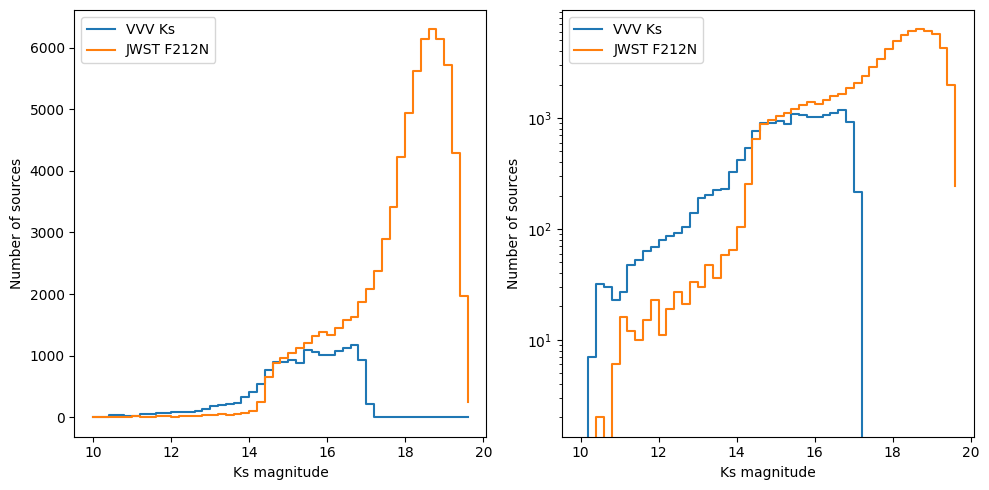

In [5]:
hist_VVV_Ks = np.histogram(cat_VVV.catalog['Ksmag'], bins=np.arange(10, 20, 0.2))
hist_JWST_212 = np.histogram(np.array(cat_use.band('f212n')), bins=np.arange(10, 20, 0.2))

fig = plt.figure(figsize=(10,5))

ax = plt.subplot(121)
ax.step(hist_VVV_Ks[1][:-1], hist_VVV_Ks[0], where='post', label='VVV Ks')
ax.step(hist_JWST_212[1][:-1], hist_JWST_212[0], where='post', label='JWST F212N')
plt.xlabel('Ks magnitude')
plt.ylabel('Number of sources')
plt.legend()

ax = plt.subplot(122)
ax.step(hist_VVV_Ks[1][:-1], hist_VVV_Ks[0], where='post', label='VVV Ks')
ax.step(hist_JWST_212[1][:-1], hist_JWST_212[0], where='post', label='JWST F212N')
plt.xlabel('Ks magnitude')
plt.ylabel('Number of sources')
plt.legend()
plt.yscale('log')

plt.tight_layout()

<Axes: xlabel='[H] - [KS]', ylabel='[KS]'>

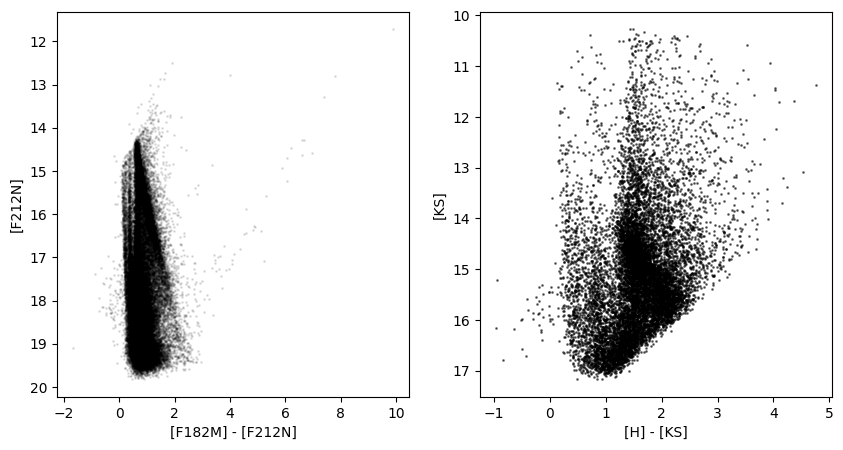

In [6]:
fig = plt.figure(figsize=(10, 5))

ax = plt.subplot(121)
cat_use.plot_CMD('f182m', 'f212n', 'f212n', s=1, color='k', alpha=0.1, ax=ax)

ax = plt.subplot(122)
cat_VVV.plot_CMD('H', 'Ks', 'Ks', s=1, color='k', alpha=0.5, ax=ax)

In [7]:
mask_overlap_jwst = cat_use.band('f212n') < 17
mask_overlap_vvv = cat_VVV.catalog['Ksmag'] > 14.5 

cat_use_overlap = JWSTCatalog(cat_use.catalog[mask_overlap_jwst])
cat_VVV_overlap = VVVCatalog(cat_VVV.catalog[mask_overlap_vvv])

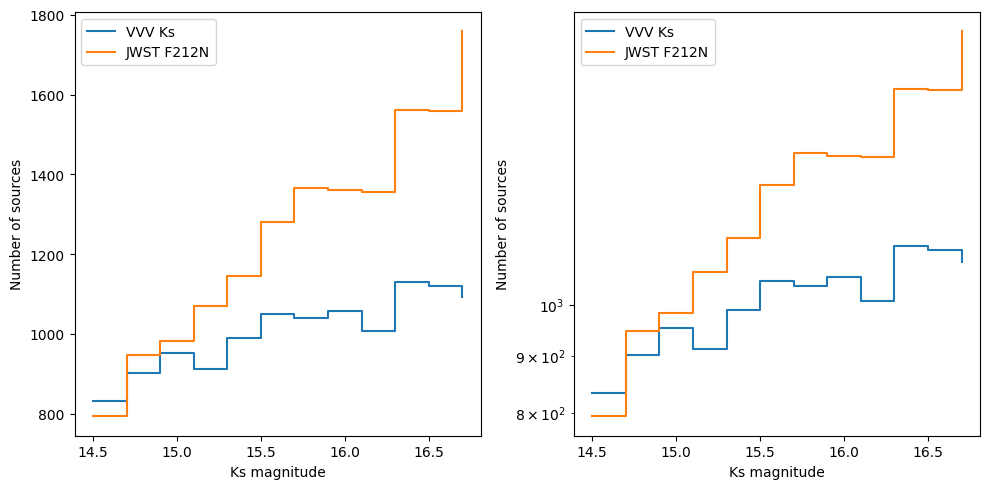

In [8]:
hist_VVV_Ks = np.histogram(np.array(cat_VVV_overlap.catalog['Ksmag']), bins=np.arange(14.5, 17, 0.2))
hist_JWST_212 = np.histogram(np.array(cat_use_overlap.band('f212n')), bins=np.arange(14.5, 17, 0.2))

fig = plt.figure(figsize=(10,5))

ax = plt.subplot(121)
ax.step(hist_VVV_Ks[1][:-1], hist_VVV_Ks[0], where='post', label='VVV Ks')
ax.step(hist_JWST_212[1][:-1], hist_JWST_212[0], where='post', label='JWST F212N')
plt.xlabel('Ks magnitude')
plt.ylabel('Number of sources')
plt.legend()

ax = plt.subplot(122)
ax.step(hist_VVV_Ks[1][:-1], hist_VVV_Ks[0], where='post', label='VVV Ks')
ax.step(hist_JWST_212[1][:-1], hist_JWST_212[0], where='post', label='JWST F212N')
plt.xlabel('Ks magnitude')
plt.ylabel('Number of sources')
plt.legend()
plt.yscale('log')

plt.tight_layout()

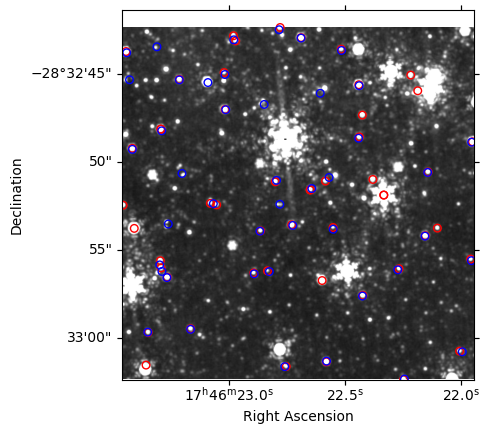

In [9]:
pos_1 = SkyCoord('17:46:22.7004243086 -28:32:52.3581961071', unit=(u.hourangle, u.deg), frame='icrs')
l = 20*u.arcsec
w = 20*u.arcsec
cutout_close = get_cutout_405(pos_1, w=w, l=l)
reg_close = regions.RectangleSkyRegion(pos_1, width=l, height=w)

ax = plt.subplot(111, projection=cutout_close.wcs)
ax.imshow(cutout_close.data, origin='lower', cmap='gray', vmin=0, vmax=50)
cat_use_overlap_trimmed = JWSTCatalog(cat_use_overlap.table_region_mask([reg_close], cutout_close.wcs))
cat_use_overlap_trimmed.plot_position(ax=ax, s=30, edgecolor='red', facecolor='none', lw=1, transform=ax.get_transform('world'))
cat_VVV_overlap_trimmed = VVVCatalog(cat_VVV_overlap.table_region_mask([reg_close], cutout_close.wcs))
cat_VVV_overlap_trimmed.plot_position(ax=ax, s=30, edgecolor='blue', facecolor='none', lw=1, transform=ax.get_transform('world'))

#cat_use_overlap.plot_position(ax=ax, s=30, edgecolor='red', facecolor='none', lw=1, transform=ax.get_transform('world'))

In [10]:
jwst_coords = SkyCoord(cat_use_overlap.ra, cat_use_overlap.dec, unit=u.deg, frame='icrs')
vvv_coords = SkyCoord(cat_VVV_overlap.ra, cat_VVV_overlap.dec, unit=u.deg, frame='icrs')

In [27]:
jwst_catalog = cat_use_overlap.catalog
jwst_catalog.meta['catalog_name'] = 'JWST'
vvv_catalog = cat_VVV_overlap.catalog
vvv_catalog.meta['catalog_name'] = 'VVV'

jwst_catalog['skycoord'] = jwst_coords
vvv_catalog['skycoord'] = vvv_coords

max_offset = 0.1*u.arcsec

basecrds = jwst_coords.copy()
crds = vvv_coords.copy()

matches, sep, _ = crds.match_to_catalog_sky(basecrds, nthneighbor=1)
reverse_matches, reverse_sep, _ = basecrds.match_to_catalog_sky(crds, nthneighbor=1)
mutual_matches = (reverse_matches[matches] == np.arange(len(matches)))

newcrds = crds[(sep > max_offset) & (~mutual_matches)]
basecrds = SkyCoord([basecrds,newcrds])

print('Base coord length = ', len(basecrds))
print('Added new sources = ', len(newcrds))

Base coord length =  19230
Added new sources =  2020


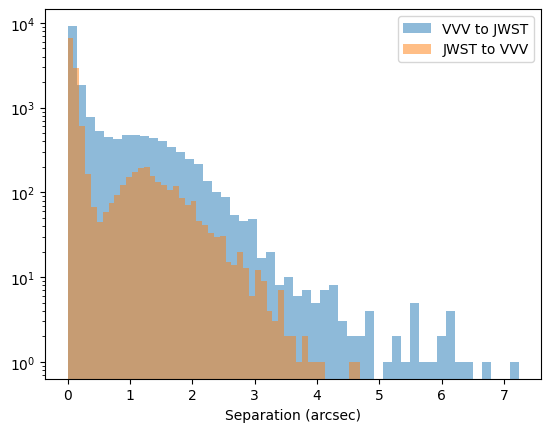

In [28]:
h_ = plt.hist(reverse_sep.to(u.arcsec).value, bins=50, alpha=0.5, label='VVV to JWST')
h = plt.hist(sep.to(u.arcsec).value, bins=50, alpha=0.5, label='JWST to VVV')
plt.yscale('log')
plt.xlabel('Separation (arcsec)')
plt.legend()

In [30]:
basetable = Table()
basetable['skycoord_ref'] = basecrds

tbls = [jwst_catalog, vvv_catalog]

for tb in tbls:
    # Grabbing the suffix we set earlier for the column names
    wl = tb.meta['catalog_name']

    crds = tb['skycoord']

    # Matching each catalog to the basecrds catalog we made earlier
    matches, sep, _ = basecrds.match_to_catalog_sky(crds, nthneighbor=1)
    reverse_matches, reverse_sep, _ = crds.match_to_catalog_sky(basecrds, nthneighbor=1)
    mutual_matches = (reverse_matches[matches] == np.arange(len(matches)))

    # Adding in columns for the separation and the match ID
    basetable.add_column(name=f"sep_{wl}", col=sep)
    basetable.add_column(name=f"id_{wl}", col=matches)
    matchtb = tb[matches]
    badsep = sep > max_offset

    # Combining the catalogs fully by including all of their columns
    for cn in matchtb.colnames:
        if isinstance(matchtb[cn], SkyCoord):
            matchtb.rename_column(cn, f"{cn}_{wl}")
            matchtb[f'mask_{wl}'] = badsep
        else:
            matchtb[f'{cn}_{wl}'] = MaskedColumn(data=matchtb[cn], name=f'{cn}_{wl}')
            matchtb[f'{cn}_{wl}'].mask[badsep] = True
            # mask non-mutual matches
            matchtb[f'{cn}_{wl}'].mask[~mutual_matches] = True
            if hasattr(matchtb[cn], 'meta'):
                matchtb[f'{cn}_{wl}'].meta = matchtb[cn].meta
            matchtb.remove_column(cn)

    basetable = table.hstack([basetable, matchtb], join_type='exact')

In [31]:
basetable[:3]

skycoord_ref,sep_JWST,id_JWST,skycoord_ref_JWST,skycoord_f410m_JWST,skycoord_f212n_JWST,skycoord_f466n_JWST,skycoord_f405n_JWST,skycoord_f187n_JWST,skycoord_f182m_JWST,skycoord_JWST,mask_JWST,skycoord_ref_filtername_JWST,sep_f410m_JWST,id_f410m_JWST,flux_f410m_JWST,flux_err_f410m_JWST,mask_f410m_JWST,qfit_f410m_JWST,cfit_f410m_JWST,flux_init_f410m_JWST,flags_f410m_JWST,local_bkg_f410m_JWST,group_size_f410m_JWST,dra_f410m_JWST,ddec_f410m_JWST,std_ra_f410m_JWST,std_dec_f410m_JWST,nmatch_f410m_JWST,nmatch_good_f410m_JWST,flux_err_prop_f410m_JWST,flux_jy_f410m_JWST,mag_ab_f410m_JWST,eflux_jy_f410m_JWST,emag_ab_f410m_JWST,near_saturated_f410m_f410m_JWST,replaced_saturated_f410m_JWST,sep_f212n_JWST,id_f212n_JWST,flux_f212n_JWST,flux_err_f212n_JWST,mask_f212n_JWST,qfit_f212n_JWST,cfit_f212n_JWST,flux_init_f212n_JWST,flags_f212n_JWST,local_bkg_f212n_JWST,group_size_f212n_JWST,dra_f212n_JWST,ddec_f212n_JWST,std_ra_f212n_JWST,std_dec_f212n_JWST,nmatch_f212n_JWST,nmatch_good_f212n_JWST,flux_err_prop_f212n_JWST,flux_jy_f212n_JWST,mag_ab_f212n_JWST,eflux_jy_f212n_JWST,emag_ab_f212n_JWST,near_saturated_f212n_f212n_JWST,replaced_saturated_f212n_JWST,sep_f466n_JWST,id_f466n_JWST,flux_f466n_JWST,flux_err_f466n_JWST,mask_f466n_JWST,qfit_f466n_JWST,cfit_f466n_JWST,flux_init_f466n_JWST,flags_f466n_JWST,local_bkg_f466n_JWST,group_size_f466n_JWST,dra_f466n_JWST,ddec_f466n_JWST,std_ra_f466n_JWST,std_dec_f466n_JWST,nmatch_f466n_JWST,nmatch_good_f466n_JWST,flux_err_prop_f466n_JWST,flux_jy_f466n_JWST,mag_ab_f466n_JWST,eflux_jy_f466n_JWST,emag_ab_f466n_JWST,near_saturated_f466n_f466n_JWST,replaced_saturated_f466n_JWST,sep_f405n_JWST,id_f405n_JWST,flux_f405n_JWST,flux_err_f405n_JWST,mask_f405n_JWST,qfit_f405n_JWST,cfit_f405n_JWST,flux_init_f405n_JWST,flags_f405n_JWST,local_bkg_f405n_JWST,group_size_f405n_JWST,dra_f405n_JWST,ddec_f405n_JWST,std_ra_f405n_JWST,std_dec_f405n_JWST,nmatch_f405n_JWST,nmatch_good_f405n_JWST,flux_err_prop_f405n_JWST,flux_jy_f405n_JWST,mag_ab_f405n_JWST,eflux_jy_f405n_JWST,emag_ab_f405n_JWST,near_saturated_f405n_f405n_JWST,replaced_saturated_f405n_JWST,sep_f187n_JWST,id_f187n_JWST,flux_f187n_JWST,flux_err_f187n_JWST,mask_f187n_JWST,qfit_f187n_JWST,cfit_f187n_JWST,flux_init_f187n_JWST,flags_f187n_JWST,local_bkg_f187n_JWST,group_size_f187n_JWST,dra_f187n_JWST,ddec_f187n_JWST,std_ra_f187n_JWST,std_dec_f187n_JWST,nmatch_f187n_JWST,nmatch_good_f187n_JWST,flux_err_prop_f187n_JWST,flux_jy_f187n_JWST,mag_ab_f187n_JWST,eflux_jy_f187n_JWST,emag_ab_f187n_JWST,near_saturated_f187n_f187n_JWST,replaced_saturated_f187n_JWST,sep_f182m_JWST,id_f182m_JWST,flux_f182m_JWST,flux_err_f182m_JWST,mask_f182m_JWST,qfit_f182m_JWST,cfit_f182m_JWST,flux_init_f182m_JWST,flags_f182m_JWST,local_bkg_f182m_JWST,group_size_f182m_JWST,dra_f182m_JWST,ddec_f182m_JWST,std_ra_f182m_JWST,std_dec_f182m_JWST,nmatch_f182m_JWST,nmatch_good_f182m_JWST,flux_err_prop_f182m_JWST,flux_jy_f182m_JWST,mag_ab_f182m_JWST,eflux_jy_f182m_JWST,emag_ab_f182m_JWST,near_saturated_f182m_f182m_JWST,replaced_saturated_f182m_JWST,flux_jy_410m405_JWST,mag_ab_410m405_JWST,flux_jy_405m410_JWST,mag_ab_405m410_JWST,flux_jy_182m187_JWST,mag_ab_182m187_JWST,flux_jy_187m182_JWST,mag_ab_187m182_JWST,sep_VVV,id_VVV,skycoord_VVV,srcid_VVV,RAJ2000_VVV,DEJ2000_VVV,Nep_VVV,e_RAJ2000_VVV,e_DEJ2000_VVV,plx_VVV,e_plx_VVV,pmRA_VVV,e_pmRA_VVV,pmDE_VVV,e_pmDE_VVV,Chi2_VVV,UWE_VVV,Zmag_VVV,e_Zmag_VVV,o_Zmag_VVV,Ymag_VVV,e_Ymag_VVV,o_Ymag_VVV,Jmag_VVV,e_Jmag_VVV,o_Jmag_VVV,Hmag_VVV,e_Hmag_VVV,o_Hmag_VVV,Ksmag_VVV,e_Ksmag_VVV,o_Ksmag_VVV,KsEp1_VVV,KsEpl_VVV,KsSkew_VVV,MedKsmag_VVV,e_MedKsmag_VVV,SIKsmag_VVV,SJKsmag_VVV,SKKsmag_VVV,NSIobs_VVV,etaKs_VVV,etaKsMod_VVV,mask_VVV
"deg,deg",deg,,"deg,deg","deg,deg","deg,deg","deg,deg","deg,deg","deg,deg","deg,deg","deg,deg",,,deg,,,,,,,,,,,,,deg,deg,,,,Jy,,Jy,,,,deg,,,,,,,,,,,,,deg,deg,,,,Jy,,Jy,,,,deg,,,,,,,,,,,,,deg,deg,,,,Jy,,Jy,,,,deg,,,,,,,,,,,,,deg,deg,,,,Jy,,Jy,,,,deg,,,,,,,,,,,,,deg,deg,,,,Jy,,Jy,,,,deg,,,,,,,,,,,,,deg,deg,,,,Jy,,Jy,,,,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,deg,,"d

Text(0, 0.5, 'JWST F212N magnitude')

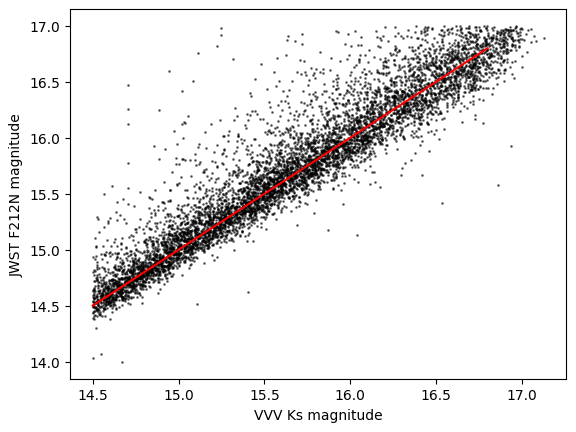

In [36]:
plt.scatter(basetable['Ksmag_VVV'], basetable['mag_ab_f212n_JWST'], s=1, color='k', alpha=0.5)
plt.plot([14.5,16.8], [14.5,16.8], color='r')
plt.xlabel('VVV Ks magnitude')
plt.ylabel('JWST F212N magnitude')

In [37]:
dra = (basetable['skycoord_VVV'].ra - basetable['skycoord_ref'].ra).to(u.arcsec)
ddec = (basetable['skycoord_VVV'].dec - basetable['skycoord_ref'].dec).to(u.arcsec)

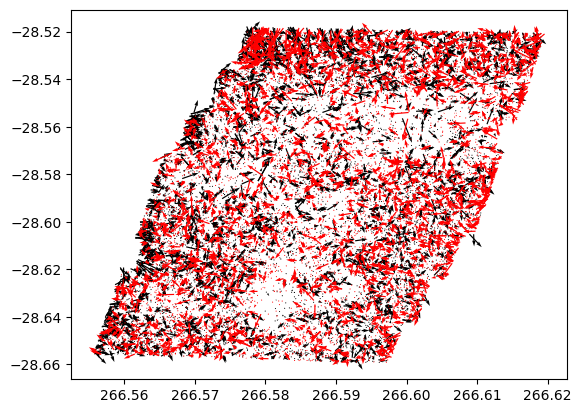

In [38]:
plt.quiver(basecrds[dra>0].ra.value, basecrds[dra>0].dec.value, dra.to(u.arcsec).value[dra>0], ddec.to(u.arcsec).value[dra>0], color='k')
plt.quiver(basecrds[dra<0].ra.value, basecrds[dra<0].dec.value, dra.to(u.arcsec).value[dra<0], ddec.to(u.arcsec).value[dra<0], color='r')

In [39]:
dra = (basetable['skycoord_JWST'].ra - basetable['skycoord_ref'].ra).to(u.arcsec)
ddec = (basetable['skycoord_JWST'].dec - basetable['skycoord_ref'].dec).to(u.arcsec)

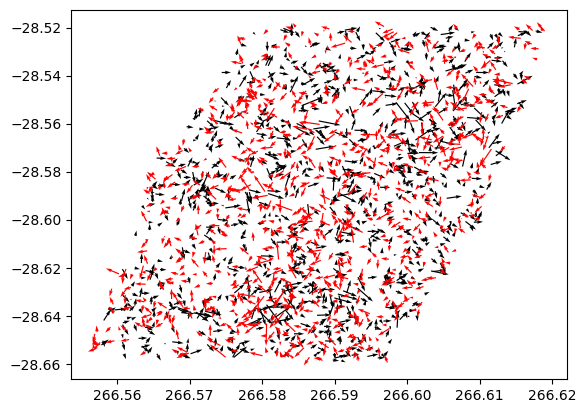

In [40]:
plt.quiver(basecrds[dra>0].ra.value, basecrds[dra>0].dec.value, dra.to(u.arcsec).value[dra>0], ddec.to(u.arcsec).value[dra>0], color='k')
plt.quiver(basecrds[dra<0].ra.value, basecrds[dra<0].dec.value, dra.to(u.arcsec).value[dra<0], ddec.to(u.arcsec).value[dra<0], color='r')


In [41]:
# proper motion vectors
basetable[:3]

skycoord_ref,sep_JWST,id_JWST,skycoord_ref_JWST,skycoord_f410m_JWST,skycoord_f212n_JWST,skycoord_f466n_JWST,skycoord_f405n_JWST,skycoord_f187n_JWST,skycoord_f182m_JWST,skycoord_JWST,mask_JWST,skycoord_ref_filtername_JWST,sep_f410m_JWST,id_f410m_JWST,flux_f410m_JWST,flux_err_f410m_JWST,mask_f410m_JWST,qfit_f410m_JWST,cfit_f410m_JWST,flux_init_f410m_JWST,flags_f410m_JWST,local_bkg_f410m_JWST,group_size_f410m_JWST,dra_f410m_JWST,ddec_f410m_JWST,std_ra_f410m_JWST,std_dec_f410m_JWST,nmatch_f410m_JWST,nmatch_good_f410m_JWST,flux_err_prop_f410m_JWST,flux_jy_f410m_JWST,mag_ab_f410m_JWST,eflux_jy_f410m_JWST,emag_ab_f410m_JWST,near_saturated_f410m_f410m_JWST,replaced_saturated_f410m_JWST,sep_f212n_JWST,id_f212n_JWST,flux_f212n_JWST,flux_err_f212n_JWST,mask_f212n_JWST,qfit_f212n_JWST,cfit_f212n_JWST,flux_init_f212n_JWST,flags_f212n_JWST,local_bkg_f212n_JWST,group_size_f212n_JWST,dra_f212n_JWST,ddec_f212n_JWST,std_ra_f212n_JWST,std_dec_f212n_JWST,nmatch_f212n_JWST,nmatch_good_f212n_JWST,flux_err_prop_f212n_JWST,flux_jy_f212n_JWST,mag_ab_f212n_JWST,eflux_jy_f212n_JWST,emag_ab_f212n_JWST,near_saturated_f212n_f212n_JWST,replaced_saturated_f212n_JWST,sep_f466n_JWST,id_f466n_JWST,flux_f466n_JWST,flux_err_f466n_JWST,mask_f466n_JWST,qfit_f466n_JWST,cfit_f466n_JWST,flux_init_f466n_JWST,flags_f466n_JWST,local_bkg_f466n_JWST,group_size_f466n_JWST,dra_f466n_JWST,ddec_f466n_JWST,std_ra_f466n_JWST,std_dec_f466n_JWST,nmatch_f466n_JWST,nmatch_good_f466n_JWST,flux_err_prop_f466n_JWST,flux_jy_f466n_JWST,mag_ab_f466n_JWST,eflux_jy_f466n_JWST,emag_ab_f466n_JWST,near_saturated_f466n_f466n_JWST,replaced_saturated_f466n_JWST,sep_f405n_JWST,id_f405n_JWST,flux_f405n_JWST,flux_err_f405n_JWST,mask_f405n_JWST,qfit_f405n_JWST,cfit_f405n_JWST,flux_init_f405n_JWST,flags_f405n_JWST,local_bkg_f405n_JWST,group_size_f405n_JWST,dra_f405n_JWST,ddec_f405n_JWST,std_ra_f405n_JWST,std_dec_f405n_JWST,nmatch_f405n_JWST,nmatch_good_f405n_JWST,flux_err_prop_f405n_JWST,flux_jy_f405n_JWST,mag_ab_f405n_JWST,eflux_jy_f405n_JWST,emag_ab_f405n_JWST,near_saturated_f405n_f405n_JWST,replaced_saturated_f405n_JWST,sep_f187n_JWST,id_f187n_JWST,flux_f187n_JWST,flux_err_f187n_JWST,mask_f187n_JWST,qfit_f187n_JWST,cfit_f187n_JWST,flux_init_f187n_JWST,flags_f187n_JWST,local_bkg_f187n_JWST,group_size_f187n_JWST,dra_f187n_JWST,ddec_f187n_JWST,std_ra_f187n_JWST,std_dec_f187n_JWST,nmatch_f187n_JWST,nmatch_good_f187n_JWST,flux_err_prop_f187n_JWST,flux_jy_f187n_JWST,mag_ab_f187n_JWST,eflux_jy_f187n_JWST,emag_ab_f187n_JWST,near_saturated_f187n_f187n_JWST,replaced_saturated_f187n_JWST,sep_f182m_JWST,id_f182m_JWST,flux_f182m_JWST,flux_err_f182m_JWST,mask_f182m_JWST,qfit_f182m_JWST,cfit_f182m_JWST,flux_init_f182m_JWST,flags_f182m_JWST,local_bkg_f182m_JWST,group_size_f182m_JWST,dra_f182m_JWST,ddec_f182m_JWST,std_ra_f182m_JWST,std_dec_f182m_JWST,nmatch_f182m_JWST,nmatch_good_f182m_JWST,flux_err_prop_f182m_JWST,flux_jy_f182m_JWST,mag_ab_f182m_JWST,eflux_jy_f182m_JWST,emag_ab_f182m_JWST,near_saturated_f182m_f182m_JWST,replaced_saturated_f182m_JWST,flux_jy_410m405_JWST,mag_ab_410m405_JWST,flux_jy_405m410_JWST,mag_ab_405m410_JWST,flux_jy_182m187_JWST,mag_ab_182m187_JWST,flux_jy_187m182_JWST,mag_ab_187m182_JWST,sep_VVV,id_VVV,skycoord_VVV,srcid_VVV,RAJ2000_VVV,DEJ2000_VVV,Nep_VVV,e_RAJ2000_VVV,e_DEJ2000_VVV,plx_VVV,e_plx_VVV,pmRA_VVV,e_pmRA_VVV,pmDE_VVV,e_pmDE_VVV,Chi2_VVV,UWE_VVV,Zmag_VVV,e_Zmag_VVV,o_Zmag_VVV,Ymag_VVV,e_Ymag_VVV,o_Ymag_VVV,Jmag_VVV,e_Jmag_VVV,o_Jmag_VVV,Hmag_VVV,e_Hmag_VVV,o_Hmag_VVV,Ksmag_VVV,e_Ksmag_VVV,o_Ksmag_VVV,KsEp1_VVV,KsEpl_VVV,KsSkew_VVV,MedKsmag_VVV,e_MedKsmag_VVV,SIKsmag_VVV,SJKsmag_VVV,SKKsmag_VVV,NSIobs_VVV,etaKs_VVV,etaKsMod_VVV,mask_VVV
"deg,deg",deg,,"deg,deg","deg,deg","deg,deg","deg,deg","deg,deg","deg,deg","deg,deg","deg,deg",,,deg,,,,,,,,,,,,,deg,deg,,,,Jy,,Jy,,,,deg,,,,,,,,,,,,,deg,deg,,,,Jy,,Jy,,,,deg,,,,,,,,,,,,,deg,deg,,,,Jy,,Jy,,,,deg,,,,,,,,,,,,,deg,deg,,,,Jy,,Jy,,,,deg,,,,,,,,,,,,,deg,deg,,,,Jy,,Jy,,,,deg,,,,,,,,,,,,,deg,deg,,,,Jy,,Jy,,,,Jy,Jy,Jy,Jy,Jy,Jy,Jy,Jy,deg,,"d

In [72]:
dra = basetable['pmRA_VVV']
dra[dra.mask] = np.nan
ddec = basetable['pmDE_VVV']
ddec[ddec.mask] = np.nan

In [73]:
np.array(dra)

array([         nan,  -3.92611421,          nan, ...,   1.1162252 ,
        29.36823129, 788.472087  ])

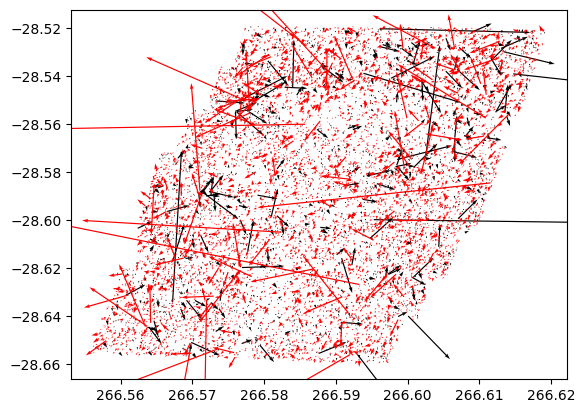

In [74]:
plt.quiver(basecrds[dra>0].ra.value, basecrds[dra>0].dec.value, dra[dra>0], ddec[dra>0], color='k')
plt.quiver(basecrds[dra<0].ra.value, basecrds[dra<0].dec.value, dra[dra<0], ddec[dra<0], color='r')

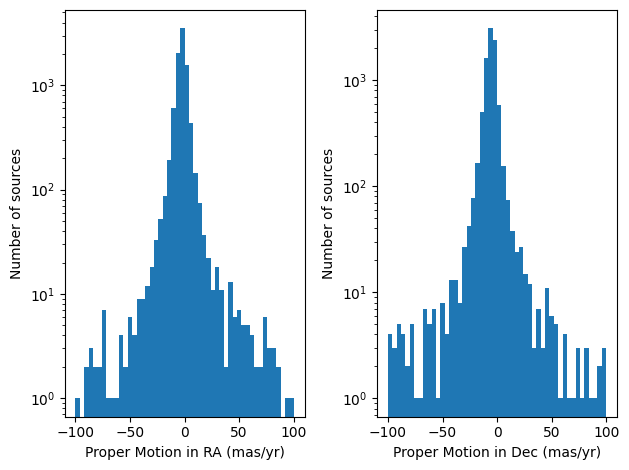

In [75]:
ax = plt.subplot(121)
h_ra = plt.hist(dra.to(u.mas/u.yr).value, bins=50, range=(-100,100))
plt.yscale('log')
plt.xlabel('Proper Motion in RA (mas/yr)')
plt.ylabel('Number of sources')
ax = plt.subplot(122)
h_dec = plt.hist(ddec.to(u.mas/u.yr).value, bins=50, range=(-100,100))
plt.yscale('log')
plt.xlabel('Proper Motion in Dec (mas/yr)')
plt.ylabel('Number of sources')

plt.tight_layout()

Text(0, 0.5, 'Number of sources')

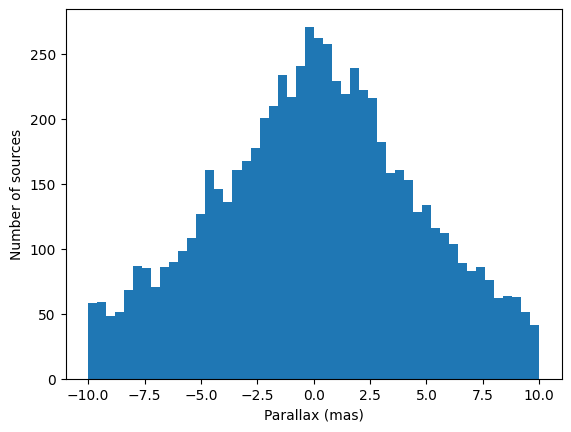

In [80]:
ax = plt.subplot(111)
plx = basetable['plx_VVV']
plx[plx.mask] = np.nan
h_plx = plt.hist(plx.to(u.mas).value, bins=50, range=(-10, 10))
plt.xlabel('Parallax (mas)')
plt.ylabel('Number of sources')